# Predicting Gout During Emergency Room Visit: 
## <i>Is the patient potentially suffering from Gout?</i>  

## Scope

The scope of this project is corpora from the Deep South.  The demographics of the population from which they were derived are 54% female, and 46% male, 55% Black, 40% White, 2% Hispanic, and 1% Asian. Age distribution was 5% between ages 1-20 years, 35% between ages 21-40 years, 35% between ages 41-60 years, 20% between ages 61-80 years, and 5% between ages 81-100 years.

## Data

The data is extracted in csv format from the MIMIC-III (Medical Information Mart for Intensive Care III) database.  Details can be found at https://physionet.org/content/emer-complaint-gout/1.0/.   Acces to the database may be requested at (https://mimic.physionet.org/gettingstarted/access/). 

The data provided by the MIMIC database consists of 2 corpora of free text collected by the triage nurse and recorded as the "Chief Complaint".  Each complaint contains up to 282 characters in length and was collected from 2019 to 2020 at an academic medical center in the Deep South.  The 2019 corpora, "GOUT-CC-2019-CORPUS", consists of 300 chief complaints selected by the presence of the keyword "gout". The 2020 corpora, "GOUT-CC-2020-CORPUS" contains 8037 chief complaints collected from a single month in 2020. The chief complaints included in both corpora were selected based on the presence of the keyword "gout".

## Cleaning

***Import Data***

In [1]:
import pandas as pd
syn2019 = pd.read_csv('Data/GOUT-CC-2019-CORPUS-SYNTHETIC.csv')
syn2020 = pd.read_csv('Data/GOUT-CC-2020-CORPUS-SYNTHETIC.csv')

**Data Description**
* 2 csv files
    * 2019 : 300 records
    * 2020 : 8037 records
    * Identical layouts and formats: all text, 3 columns
    <br><br>
* 3 Columns:  ["Chief Complaint", "Predict", "Consensus"]
    * <b>Chief Complaint:</b> 
        * text format
        * up to 282 Chars
        * nurse recorded patient complaint
    * <b>Predict:</b> 
        * text format
        * single char ('-','U','Y','N')
        * prediction of Gout by the ER Physician
    * <b>Consensus:</b> 
        * textformat
        * single char ('-','U','Y','N')
        * determination of Gout by the Rhuematologist
    <br>
* 
          - : Null
          U : Unknonw
          Y : Yes
          N : Gout

***Review Data***

In [2]:
print(syn2019.head())

                                     Chief Complaint Predict Consensus
0  "been feeling bad" last 2 weeks & switched BP ...       N         -
1  "can't walk", reports onset at 0830 am. orient...       Y         N
2  "dehydration" Chest hurts, hips hurt, cramps P...       Y         Y
3  "gout flare up" L arm swelling x 1 week. denie...       Y         Y
4  "heart racing,"dyspnea, and orthopnea that has...       N         -


In [3]:
print(syn2020.head())

                                     Chief Complaint Predict Consensus
0  "I dont know whats going on with my head, its ...       N         -
1  "i've been depressed for a few weeks now, i'm ...       N         -
2  Altercation while making arrest, c/o R hand pa...       N         N
3  Cut on L upper thigh wtih saw. Bleeding contro...       N         N
4   Dysuria x1 week. hx: hysterectomy, gerd, bipolar       N         -


***Combine into 1 dataframe 'df'***

In [4]:
# Combine the files into 1 dataframe
df = pd.concat([syn2019, syn2020], axis=0).reset_index(drop=True)
print(df.shape)

(8437, 3)


In [5]:
print(df.dtypes)

Chief Complaint    object
Predict            object
Consensus          object
dtype: object


## Clean Data

   * Remove records that contain null values in both of the Predict and Consensus columns.
   * Fill Consensus null values ( - ) with Predict values
   * Change all chars to lowercase
   * Remove punctuation
   * Remove words containing numbers

In [6]:
print(df['Predict'].value_counts(sort=False))

N    8168
-       2
U     156
Y     111
Name: Predict, dtype: int64


In [7]:
print(df['Consensus'].value_counts(sort=False))

N     350
-    7976
U      16
Y      95
Name: Consensus, dtype: int64


In [8]:
df = df[(df.Consensus != '-') | (df.Predict != '-')]
print(df.shape)

(8435, 3)


### Target Value Determination for a single binomial target:

For this project we are using a single binomial target.  The 'Predict' column values were reported by the ER physician treating the patient.  In comparison, the 'Consensus' values were reported by a rhuematologist when seen by a specialist.  Therefore the consensus value was considered more accurate and the consensus column chosen for the target values with the empty (-) values filled by the 'Predict' column. 

In [9]:
# REPLACE NULL VALUES IN 'Consensus' WITH THE 'Predict' VALUES
for a in df['Consensus']:
    if a == '-':
        df['Consensus'] = df['Predict']

In [10]:
# DROP REMAINING 'U', unknown, RECORDS.
df = df[df.Consensus != 'U']

In [11]:
# DROP THE 'Predict' COLUMN
df = df.drop(columns=['Predict'])

In [12]:
# CLEANUP RESULTS IN 8271 RECORDS WITH A SINGLE BINOMIAL TARGET
df.describe(include='all')

,Chief Complaint,Consensus
count,8279,8279
unique,8271,2
top,Pt stating he got into a fight 3 hrs ago and i...,N
freq,2,8168


### Rename columns and store dataframe as csv for use in BERT noteook

In [13]:
df = df.rename(columns={'Chief Complaint': 'corpus', 'Consensus': 'target'})
df

# store the cleaned data for use in a BERT Pretrained model
df.to_csv('df.csv', index=False)

**Text Cleanup**
* Convert all text to lowercase
* remove brackets ([ ])
* remove punctuation
* remove words that contain numbers
* remove quotes
* remove newline chars

In [14]:
import re
import string

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)                               # remove brackets [ ]
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # remove punctuation
    text = re.sub('\w*\d\w*', '', text)                              # remove digits embedded in words
    text = re.sub('[‘’“”…]', '', text)                               # remove quotes
    text = re.sub('\n', '', text)                                    # remove newlines
    return text

cleaning = lambda x: clean_text(x)

In [15]:
# Let's take a look at the updated text
df['corpus'] = pd.DataFrame(df['corpus'].apply(cleaning))
df

,corpus,target
0,been feeling bad last weeks switched bp medi...,N
1,cant walk reports onset at am oriented aorti...,Y
2,dehydration chest hurts hips hurt cramps pmh h...,Y
3,gout flare up l arm swelling x week denies an...,Y
4,heart racingdyspnea and orthopnea that has bee...,N
...,...,...
8432,stepped on a nail at home with right foot pain...,N
8433,i was having a breakdown rt stress and depres...,N
8434,i tried to jump in front of a car pt states sh...,N
8435,abdominal pain x week denies pmh,N


In [16]:
print(df.dtypes)

corpus    object
target    object
dtype: object


In [17]:
df['target'].value_counts()

N    8168
Y     111
Name: target, dtype: int64

## Process Raw Data for NLP
* Tokenize
* Remove Stop Words
* Lemmitization
* Stemming

### Tokenize sentences

In [18]:
import nltk
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer("[\w']+")

In [19]:
df['corpus'] = df['corpus'].apply(lambda x: tokenizer.tokenize(x.lower()))

#### Convert common medical abbreviations to longform

In [20]:
#  Dictionary of common medical abbreviations and associated longform word

pattern = {"l": "left", "L" : "left",
           "r" : "right", "R" : "right",
           "x" : "times", "cp" : "chestpain",
           "c" : "complaint", "o" : "of", "nv" : "nausea and vomiting", "w" : "with",
           "op" : "outpatient", "bm" : "bowel movement", "hld" : " hyperlipidemia",
           "hx": "history", "pmhx" : "history", "pmh" : "history",
           "tx" : "treatment", "dx" : "diagnosis", "utd" : "up to date",
           "rom" : "rangeofmotion", "sob" : "shortness of breath",
           "htn" : "hypertension", "chf" : "congestive heart failure", "esrd" : "end stage renal disease",
           "ckd" : "chronic kidney disease", "gsw" : "gunshot wound", "dm" : "diabetes mellitus",
           "ged" : "gastroesophageal reflux", "cabg" : "coronary artery bypass graft", "copd" : "cardio pulmonary disease",
           "asa" : "aspirin",
           "ct" : "ctscan", "mvc" : "motor vehicle crash",
           "can't" : "cannot", "ads's" : "activities of daily living"}

#  Extract sentence in each row, convert to string
for index, items in df.iteritems():
    list_items = " ".join([str(elem) for elem in items])
    
    # replace abbreviations using dictionary "pattern"
    items = ' '.join([pattern.get(i, i) for i in list_items.split()])

### Remove stop words

In [21]:
from nltk.corpus import stopwords
#nltk.download('stopwords')
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [22]:
df['corpus'] = df['corpus'].apply(lambda x : remove_stopwords(x))
df['corpus'].head()
df

,corpus,target
0,"[feeling, bad, last, weeks, switched, bp, medi...",N
1,"[cant, walk, reports, onset, oriented, aortic,...",Y
2,"[dehydration, chest, hurts, hips, hurt, cramps...",Y
3,"[gout, flare, l, arm, swelling, x, week, denie...",Y
4,"[heart, racingdyspnea, orthopnea, getting, wor...",N
...,...,...
8432,"[stepped, nail, home, right, foot, painful, di...",N
8433,"[breakdown, rt, stress, depression]",N
8434,"[tried, jump, front, car, pt, states, psych, m...",N
8435,"[abdominal, pain, x, week, denies, pmh]",N


In [23]:
analysis = df.copy(deep=True)  # store a copy for the wordcloud prior to lemmatization

### Perform lemmatization

In [24]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [25]:
def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

In [26]:
df['corpus'].apply(lambda x: word_lemmatizer(x))

0       [feeling, bad, last, week, switched, bp, medic...
1       [cant, walk, report, onset, oriented, aortic, ...
2       [dehydration, chest, hurt, hip, hurt, cramp, p...
3       [gout, flare, l, arm, swelling, x, week, denie...
4       [heart, racingdyspnea, orthopnea, getting, wor...
                              ...                        
8432    [stepped, nail, home, right, foot, painful, di...
8433                  [breakdown, rt, stress, depression]
8434    [tried, jump, front, car, pt, state, psych, me...
8435              [abdominal, pain, x, week, denies, pmh]
8436    [rashsores, across, body, infection, ro, left,...
Name: corpus, Length: 8279, dtype: object

### Perform stemming

In [27]:
from nltk.stem.porter import PorterStemmer
#from nltk.stem.porter import *
stemmer = PorterStemmer()

In [28]:
def word_stemmer(text):
    stem_text = ' '.join([stemmer.stem(i) for i in text])
    return stem_text

In [29]:
df['corpus'] = df['corpus'].apply(lambda x: word_stemmer(x))
df

,corpus,target
0,feel bad last week switch bp medic last week w...,N
1,cant walk report onset orient aortic valv repl...,Y
2,dehydr chest hurt hip hurt cramp pmh hip repla...,Y
3,gout flare l arm swell x week deni pmh,Y
4,heart racingdyspnea orthopnea get wors last da...,N
...,...,...
8432,step nail home right foot pain difficult walk ...,N
8433,breakdown rt stress depress,N
8434,tri jump front car pt state psych med pmh arth...,N
8435,abdomin pain x week deni pmh,N


### END OF CLEANING....Store dataframe for modeling

In [30]:
import pandas as pd
import pickle
pd.to_pickle(df, 'modeling.csv')

## ANALYSIS
* Wordcloud
* Word Count
* Visual comparisons of word frequencies

#### WORDCLOUD

In [31]:
df = analysis.copy()   # Revert back to pre-lemmatized version of corpus

In [32]:
all_spam_cleaned = []
data = df['corpus'].copy(deep=True)
for text in data:
    text = [x.strip(string.punctuation) for x in text]
    all_spam_cleaned.append(text)

all_spam_cleaned[0]

text_spam = [" ".join(text) for text in all_spam_cleaned]
final_text_spam = " ".join(text_spam)
final_text_spam[:500]

'feeling bad last weeks switched bp medications last week worried bp pmhx chf htn gout strokes dm cant walk reports onset oriented aortic valve replacement may wife reports episode similar last week hospitalized wiregrass medical center uti gout pmhx cva l side residual deficits dehydration chest hurts hips hurt cramps pmh hip replacement gout missed pain clinic appt today thinks gout flair knee foot pain gout flare l arm swelling x week denies pmh heart racingdyspnea orthopnea getting worse last'

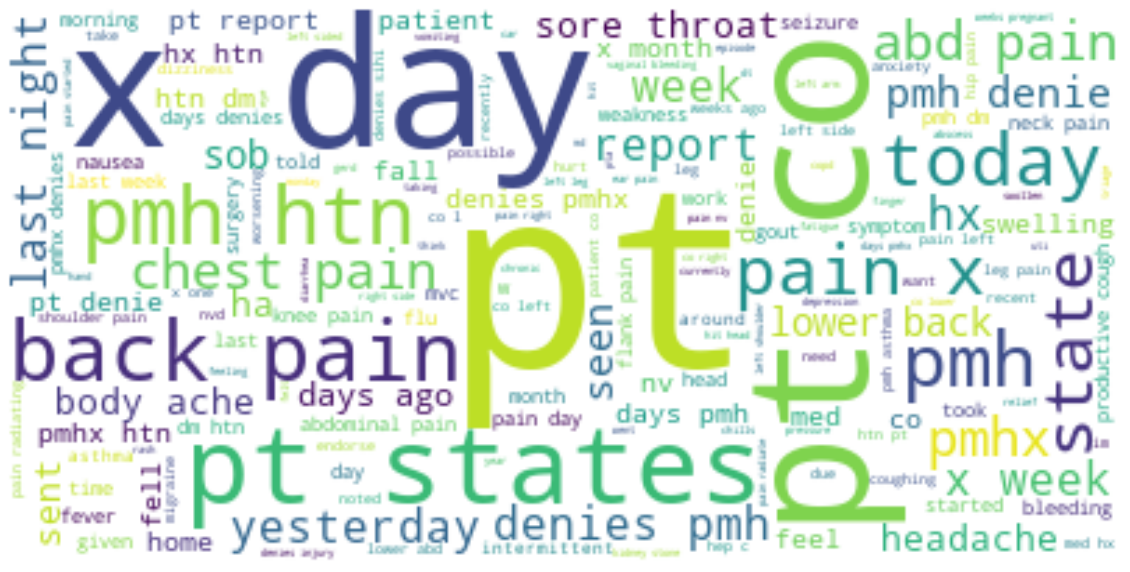

In [33]:
# Generate wordcloud from the final_text_spam string processed above

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Use the WordCloud Module
wordcloud_spam = WordCloud(background_color="white").generate(final_text_spam)

# Plot the wordcloug
plt.figure(figsize = (20,20))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.show()

### Word Count

***The number of times a word is used can be visualized below for 1) All patients, 2) Patients with Gout, 3) Patients without Gout***


* Each wordcount is calculated using the following steps
    * Vector the data
    * Aggregate on words
    * Sort by count
    * Plot the results

In [34]:
### Separate the patients that have Gout from those who do not for comparison

yes_gout = df.loc[df['target'] == 'Y']
no_gout = df.loc[df['target'] == 'N']

In [35]:
# Set Font for Charts

fontT = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
fontL = {'family': 'serif',
        'color':  'green',
        'weight': 'normal',
        'size': 16,
        }

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

def plotChart(corpus, xlabel):
    vectorizer = CountVectorizer(ngram_range=(1, 1))
    vectorized = vectorizer.fit_transform(corpus.astype(str))
    vectored_data = pd.DataFrame.sparse.from_spmatrix(vectorized, columns=vectorizer.get_feature_names())

    allData = vectored_data.sum(axis=0)
    allData = allData.sort_values(ascending=False).head(40)

        #plot
    plt.figure(figsize=(12, 8))
    plt.title("Word Count for Complete Corpus", fontdict = fontT)
    plt.xlabel(xlabel, fontdict = fontL)
    plt.ylabel("Words used by patients", fontdict = fontL)
    allData.plot.barh()
    return allData.sort_values(ascending=False)

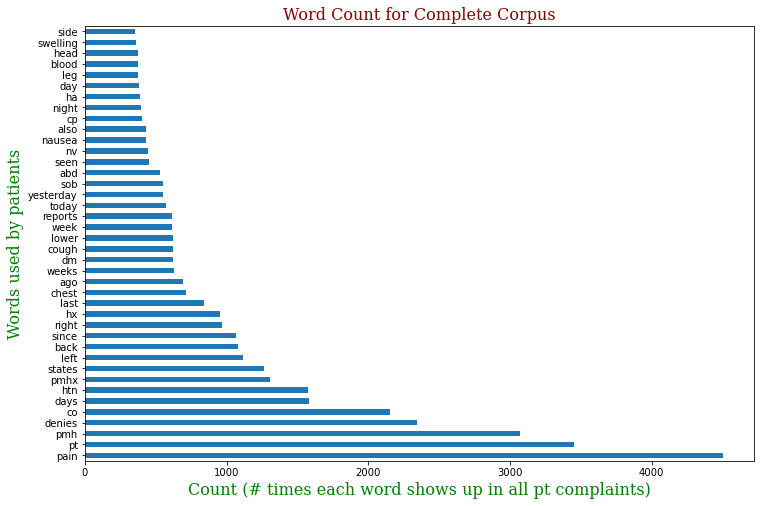

In [37]:
all_df = df.copy(deep=True)
label = "Count (# times each word shows up in all pt complaints)"
all = plotChart(all_df['corpus'], label)

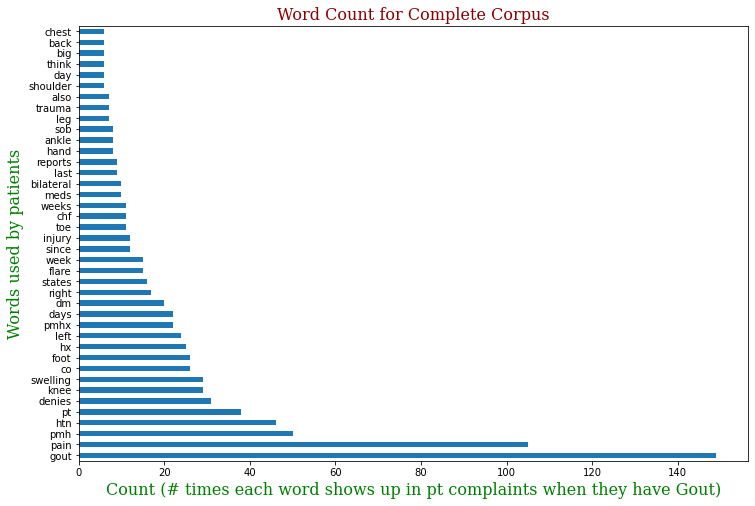

In [38]:
label = "Count (# times each word shows up in pt complaints when they have Gout)"
yes = plotChart(yes_gout['corpus'], label)

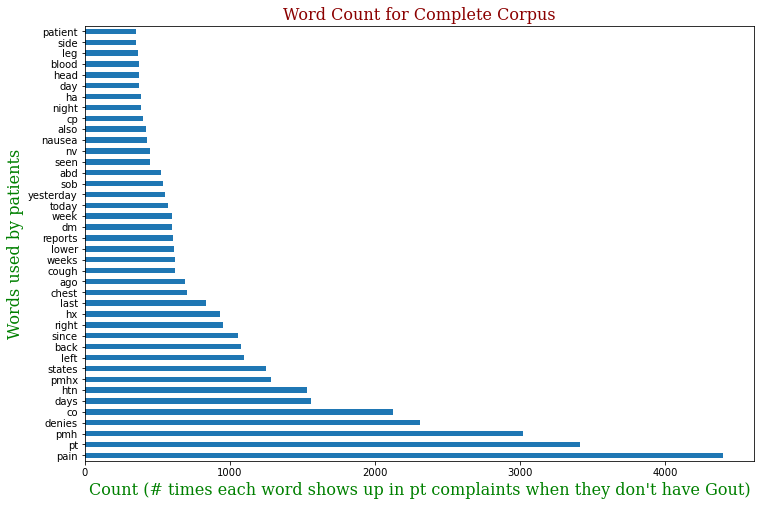

In [39]:
label = "Count (# times each word shows up in pt complaints when they don't have Gout)"
noGout = plotChart(no_gout['corpus'], label)

### Visual comparisons of word frequencies: Compare words used by Gout patients vs patients without Gout

In [40]:
noGout = noGout.to_frame().reset_index()
yes = yes.to_frame().reset_index()

In [41]:
noGout['Gout'] = 'n'
yes['Gout'] = 'y'

In [42]:
noGout = noGout.rename(columns={0: 'count'})  # Set the first column name to 'count'
yes = yes.rename(columns={0: 'count'})

In [44]:
sumN = noGout['count'].sum()                               
sumY = yes['count'].sum()
noGout['count'] = noGout['count'].apply(lambda x: x/sumN)
yes['count'] = yes['count'].apply(lambda x: x/sumY)

In [45]:
# Combine all data into single df for plotting

compare = pd.concat([noGout, yes])

Text(0, 0.5, 'Word used by patient')

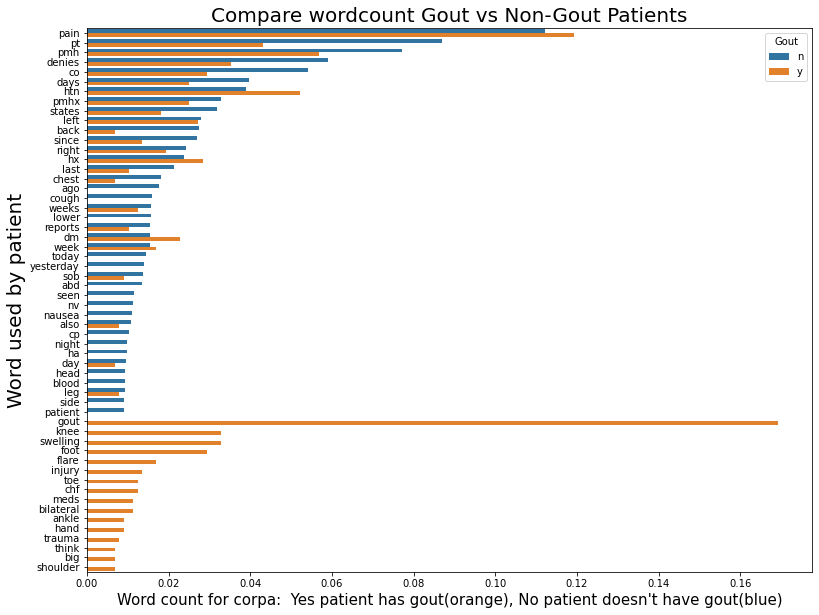

In [47]:
# Plot the comparisons

import seaborn as sns
fig_dims = (13, 10)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x="count", y="index", hue="Gout", ax=ax, data=compare)
ax.set_title("Compare wordcount Gout vs Non-Gout Patients",fontsize=20)
ax.set_xlabel("Word count for corpa:  Yes patient has gout(orange), No patient doesn't have gout(blue)",fontsize=15)
ax.set_ylabel("Word used by patient",fontsize=20)

### We see a nice separation of tokens with the expected overlap of 'pain, left, right, and dm (diabetes), with separations occuring on lung and abdominal complaints versus swelling and joint complaints.  Looks good